In [46]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [47]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
#yen_futures.dtypes
#yen_futures.index
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [48]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [49]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
yen_futures['Return'] = yen_futures.Settle.pct_change() * 100
yen_futures= yen_futures.replace(-np.inf, np.nan).dropna()
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509


### Lagged Returns 

In [50]:
# Create a lagged return using the shift function
yen_futures['Lagged_Return'] = yen_futures['Return'].shift()
yen_futures.dropna(inplace = True)
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.369458
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335,-0.564304
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509,0.151335


### Train Test Split

In [51]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2018']
test = yen_futures['2019':]

In [52]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [53]:
X_train

,Lagged_Return
Date,
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
2014-02-25,0.020502
2014-02-26,0.327970
2014-02-27,-0.296251
2014-02-28,0.389344
2014-03-03,0.275566


# Linear Regression Model

In [54]:
# Create a Linear Regression model and fit it to the training data
#from sklearn.linear_model import LinearRegression
model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [55]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [56]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
results = y_test.to_frame()
results["Predicted Return"] = predictions
results.head(20)

,Return,Predicted Return
Date,,
2019-01-02,0.430705,-0.010193
2019-01-03,1.346290,-0.007905
2019-01-04,-0.717767,-0.016882
2019-01-07,-0.091718,0.003354
2019-01-08,-0.048601,-0.002784
2019-01-09,0.329569,-0.003206
2019-01-10,-0.161551,-0.006914
2019-01-11,-0.075512,-0.002099
2019-01-14,0.269891,-0.002942


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B881356088>,
      dtype=object)

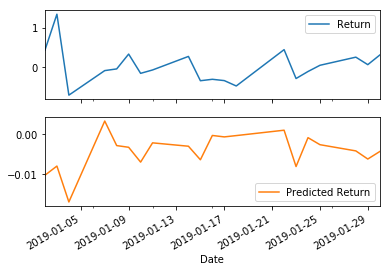

In [57]:
# Plot the first 20 predictions vs the true values
results[:20].plot(subplots=True)

**NOTE: The starter code for this file shows the above plots for 2018 rather than 2019. The train/test, accroding to the starter code file was to be created for the data using 2018-2019 for testing. If I create a train/test split for the data using 2018 and 2018 as noted below, it would produce the same graphs as shown in the starter code file.**

train = yen_futures[:'2018']

test = yen_futures['2018':]

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [58]:
#from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    results["Return"],
    results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.39649005208597526


**NOTE: The starter code for this file shows the above solution *Out-of-Sample Root Mean Squared Error (RMSE): 0.41521675083603804*. The train/test, accroding to the starter code file was to be created for the data using 2018-2019 for testing. If I create a train/test split for the data using 2018 and 2018 as noted below, it would produce an *Out-of-Sample Root Mean Squared Error (RMSE): 0.41521675083603804* .**

train = yen_futures[:'2018']

test = yen_futures['2018':]

# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [59]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["in-sample predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["in-sample predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.5658708047560468


# Conclusions

YOUR CONCLUSIONS HERE!

**Use the results of the linear regression analysis and modeling to answer the following question:**

- *Does this model perform better or worse on out-of-sample data compared to in-sample data?*

### Hints and Considerations

* Out-of-sample data is data that the model hasn't seen before (Testing data).
* In-sample data is data that the model was trained on (Training data).

**In this particular model, the out-of-sample model performed better than the in-sample modelbecuase the out-of-sample had a root mean squared error of 0.39649005208597526, while the in-sample data has an RMSE of 0.5658708047560468.**

*NOTE: If the RMSE of the test set was higher than the training data, then we would have concluded that we overfit the model. In other words, the model tests well in-sample but would not be very predictive out of sample.*